In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error

In [2]:
def prep_clf(obs,pre, threshold=0.1):
    '''
    func: 计算二分类结果-混淆矩阵的四个元素
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    
    returns:
        hits, misses, falsealarms, correctnegatives
        #aliases: TP, FN, FP, TN 
    '''
    #根据阈值分类为 0, 1
    obs = np.where(obs >= threshold, 1, 0)
    pre = np.where(pre >= threshold, 1, 0)

    # True positive (TP)
    hits = np.sum((obs == 1) & (pre == 1))

    # False negative (FN)
    misses = np.sum((obs == 1) & (pre == 0))

    # False positive (FP)
    falsealarms = np.sum((obs == 0) & (pre == 1))

    # True negative (TN)
    correctnegatives = np.sum((obs == 0) & (pre == 0))

    return hits, misses, falsealarms, correctnegatives


def precision(obs, pre, threshold=0.1):
    '''
    func: 计算精确度precision: TP / (TP + FP)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    
    returns:
        dtype: float
    '''

    TP, FN, FP, TN = prep_clf(obs=obs, pre = pre, threshold=threshold)

    return TP / (TP + FP)


def recall(obs, pre, threshold=0.1):
    '''
    func: 计算召回率recall: TP / (TP + FN)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    
    returns:
        dtype: float
    '''

    TP, FN, FP, TN = prep_clf(obs=obs, pre = pre, threshold=threshold)

    return TP / (TP + FN)


def ACC(obs, pre, threshold=0.1):
    '''
    func: 计算准确度Accuracy: (TP + TN) / (TP + TN + FP + FN)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    
    returns:
        dtype: float
    '''

    TP, FN, FP, TN = prep_clf(obs=obs, pre = pre, threshold=threshold)

    return (TP + TN) / (TP + TN + FP + FN)

def FSC(obs, pre, threshold=0.1):
    '''
    func:计算f1 score = 2 * ((precision * recall) / (precision + recall))
    '''
    precision_socre = precision(obs, pre, threshold=threshold)
    recall_score = recall(obs, pre, threshold=threshold)

    return 2 * ((precision_socre * recall_score) / (precision_socre + recall_score))
def TS(obs, pre, threshold=0.1):
    
    '''
    func: 计算TS评分: TS = hits/(hits + falsealarms + misses) 
    	  alias: TP/(TP+FP+FN)
    inputs:
        obs: 观测值，即真实值；
        pre: 预测值；
        threshold: 阈值，判别正负样本的阈值,默认0.1,气象上默认格点 >= 0.1才判定存在降水。
    returns:
        dtype: float
    '''

    hits, misses, falsealarms, correctnegatives = prep_clf(obs=obs, pre = pre, threshold=threshold)

    return hits/(hits + falsealarms + misses) 

def func_evaluation(y_real, y_pred, verbose=True):
    """
    y_real: real values
    y_pred: prediction values
    MAKE THEM HAVE THE SHAPE OF (N,) FIRST BY USING ndarray.ravel()
    """
    if not isinstance(y_real, np.ndarray):
        y_real = np.array(y_real)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)
    y_real = y_real.ravel()
    y_pred = y_pred.ravel()

    # MAPE
    def cal_mape(y_true, y_pred):
        #y_true = np.where(y_true == 0, 0.1, y_true)  # To avoid zeros.
        mape = np.mean(abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel()))
        return mape

    m0 = stats.pearsonr(y_real, y_pred)[0]
    m1 = r2_score(y_real, y_pred)
    m2 = explained_variance_score(y_real, y_pred)
    m3 = mean_squared_error(y_real, y_pred)
    m3 = np.sqrt(m3)
    m4 = mean_absolute_error(y_real, y_pred)
    m5 = cal_mape(y_real, y_pred)
    if verbose:
        print("模型的评估结果:")
        print(
            'PersonR: %f \nR2: %f \nExplained Variance: %f \nRMSE: %f \nMAE: %f \nMAPE: %f'
            % (m0, m1, m2, m3, m4, m5))
    return m0,m1, m2, m3, m4, m5

In [3]:
path='/home/liuli/GTS_GFS_MOS/multi_para_mos/evaluate/win/'
model=['catboost','lgboost','RandomForest','xgboost']
#ts=np.array([])
m0=np.array([])
m3=np.array([])
m4=np.array([])

for cc in range(0,len(model)):   
    mulu = glob.glob(path+model[cc]+'/*')
    mulu.sort()
    for ii,file in enumerate(mulu):
        filedata= pd.read_csv(file,sep=',')
        df=pd.DataFrame(filedata)
        df=df.fillna(0)
        #print(df)
        #df中pre和true间隔排列，共40行，80列，开始计算TS评分
        for i in range(1,41):
            col_pre='pre_%i' % i       
            col_obs='tru_%i' % i
            
            #ts=np.append(ts,TS(df[col_obs],df[col_pre], threshold=0.1))
            m0_temp, m1_temp, m2_temp, m3_temp, m4_temp, m5_temp=func_evaluation(df[col_obs],df[col_pre])
            m0=np.append(m0,m0_temp)
            m3=np.append(m3,m3_temp)
            m4=np.append(m4,m4_temp)

print(m0)        

模型的评估结果:
PersonR: 0.844367 
R2: 0.486273 
Explained Variance: 0.623279 
RMSE: 5.529159 
MAE: 4.500253 
MAPE: 0.225639
模型的评估结果:
PersonR: 0.853621 
R2: 0.473733 
Explained Variance: 0.629086 
RMSE: 5.558960 
MAE: 4.498874 
MAPE: 0.230263
模型的评估结果:
PersonR: 0.850387 
R2: 0.387655 
Explained Variance: 0.582691 
RMSE: 6.057338 
MAE: 4.626194 
MAPE: 0.224831
模型的评估结果:
PersonR: 0.766314 
R2: 0.338117 
Explained Variance: 0.469945 
RMSE: 6.193768 
MAE: 4.527490 
MAPE: 0.220594
模型的评估结果:
PersonR: 0.798766 
R2: 0.406020 
Explained Variance: 0.525272 
RMSE: 5.851462 
MAE: 4.646136 
MAPE: 0.240297
模型的评估结果:
PersonR: 0.723209 
R2: 0.350812 
Explained Variance: 0.501066 
RMSE: 6.150694 
MAE: 4.480552 
MAPE: 0.217523
模型的评估结果:
PersonR: 0.817297 
R2: 0.466906 
Explained Variance: 0.567730 
RMSE: 5.645561 
MAE: 4.420524 
MAPE: 0.236191
模型的评估结果:
PersonR: 0.829262 
R2: 0.480059 
Explained Variance: 0.606707 
RMSE: 5.599296 
MAE: 4.317740 
MAPE: 0.209284
模型的评估结果:
PersonR: 0.838221 
R2: 0.489431 
Explained Vari

模型的评估结果:
PersonR: 0.918068 
R2: 0.725665 
Explained Variance: 0.803048 
RMSE: 4.770620 
MAE: 3.785444 
MAPE: 0.100038
模型的评估结果:
PersonR: 0.883748 
R2: 0.668846 
Explained Variance: 0.719397 
RMSE: 3.864563 
MAE: 2.893339 
MAPE: 0.118776
模型的评估结果:
PersonR: 0.906554 
R2: 0.693369 
Explained Variance: 0.749801 
RMSE: 3.683300 
MAE: 2.969780 
MAPE: 0.124417
模型的评估结果:
PersonR: 0.877813 
R2: 0.620226 
Explained Variance: 0.691260 
RMSE: 4.049993 
MAE: 3.274977 
MAPE: 0.139084
模型的评估结果:
PersonR: 0.832199 
R2: 0.539189 
Explained Variance: 0.641698 
RMSE: 4.454496 
MAE: 3.302693 
MAPE: 0.135306
模型的评估结果:
PersonR: 0.838740 
R2: 0.553516 
Explained Variance: 0.667343 
RMSE: 4.109670 
MAE: 3.172153 
MAPE: 0.131528
模型的评估结果:
PersonR: 0.890982 
R2: 0.688404 
Explained Variance: 0.768170 
RMSE: 3.374735 
MAE: 2.737726 
MAPE: 0.120927
模型的评估结果:
PersonR: 0.882716 
R2: 0.644394 
Explained Variance: 0.709411 
RMSE: 3.532924 
MAE: 2.619378 
MAPE: 0.112456
模型的评估结果:
PersonR: 0.855826 
R2: 0.594388 
Explained Vari

模型的评估结果:
PersonR: 0.717491 
R2: 0.159460 
Explained Variance: 0.254227 
RMSE: 14.931597 
MAE: 12.119875 
MAPE: 0.428875
模型的评估结果:
PersonR: 0.534011 
R2: 0.090813 
Explained Variance: 0.162974 
RMSE: 15.738006 
MAE: 12.804241 
MAPE: 0.468076
模型的评估结果:
PersonR: 0.744338 
R2: 0.143991 
Explained Variance: 0.257630 
RMSE: 15.805059 
MAE: 12.652312 
MAPE: 0.425452
模型的评估结果:
PersonR: 0.752674 
R2: 0.134670 
Explained Variance: 0.229672 
RMSE: 16.134284 
MAE: 12.940813 
MAPE: 0.449962
模型的评估结果:
PersonR: 0.672896 
R2: 0.114570 
Explained Variance: 0.208149 
RMSE: 16.825462 
MAE: 13.634876 
MAPE: 0.472184
模型的评估结果:
PersonR: 0.774821 
R2: 0.228842 
Explained Variance: 0.313530 
RMSE: 15.693888 
MAE: 12.624140 
MAPE: 0.440865
模型的评估结果:
PersonR: 0.802322 
R2: 0.165391 
Explained Variance: 0.246425 
RMSE: 15.811862 
MAE: 13.130277 
MAPE: 0.466099
模型的评估结果:
PersonR: 0.800688 
R2: 0.234350 
Explained Variance: 0.279556 
RMSE: 15.019627 
MAE: 12.485336 
MAPE: 0.467419
模型的评估结果:
PersonR: 0.779676 
R2: 0.279442

模型的评估结果:
PersonR: -0.091794 
R2: -0.652393 
Explained Variance: -0.108199 
RMSE: 8.435168 
MAE: 6.099748 
MAPE: 0.232494
模型的评估结果:
PersonR: 0.340304 
R2: -0.318298 
Explained Variance: 0.115788 
RMSE: 7.061722 
MAE: 5.174188 
MAPE: 0.204564
模型的评估结果:
PersonR: 0.587598 
R2: -0.091500 
Explained Variance: 0.289499 
RMSE: 6.316195 
MAE: 4.728950 
MAPE: 0.190240
模型的评估结果:
PersonR: 0.103439 
R2: -0.392943 
Explained Variance: -0.031498 
RMSE: 6.992240 
MAE: 5.196751 
MAPE: 0.215301
模型的评估结果:
PersonR: 0.045733 
R2: -0.403636 
Explained Variance: -0.048961 
RMSE: 7.245413 
MAE: 5.327985 
MAPE: 0.222755
模型的评估结果:
PersonR: 0.424669 
R2: -0.249839 
Explained Variance: 0.159586 
RMSE: 6.971314 
MAE: 4.986840 
MAPE: 0.199441
模型的评估结果:
PersonR: 0.371666 
R2: -0.090768 
Explained Variance: 0.137993 
RMSE: 5.842508 
MAE: 4.532766 
MAPE: 0.202338
模型的评估结果:
PersonR: 0.268037 
R2: -0.172233 
Explained Variance: 0.067609 
RMSE: 6.237501 
MAE: 4.452414 
MAPE: 0.196821
模型的评估结果:
PersonR: 0.119140 
R2: -0.221938 
E

模型的评估结果:
PersonR: 0.983313 
R2: 0.867199 
Explained Variance: 0.899395 
RMSE: 2.811207 
MAE: 2.154472 
MAPE: 0.104817
模型的评估结果:
PersonR: 0.977520 
R2: 0.839322 
Explained Variance: 0.881388 
RMSE: 3.071629 
MAE: 2.275479 
MAPE: 0.113346
模型的评估结果:
PersonR: 0.979537 
R2: 0.822796 
Explained Variance: 0.874856 
RMSE: 3.258518 
MAE: 2.329531 
MAPE: 0.105444
模型的评估结果:
PersonR: 0.977138 
R2: 0.852576 
Explained Variance: 0.877223 
RMSE: 2.923134 
MAE: 2.312915 
MAPE: 0.119287
模型的评估结果:
PersonR: 0.976874 
R2: 0.828615 
Explained Variance: 0.867851 
RMSE: 3.143153 
MAE: 2.438499 
MAPE: 0.123014
模型的评估结果:
PersonR: 0.968393 
R2: 0.813357 
Explained Variance: 0.843076 
RMSE: 3.297950 
MAE: 2.259597 
MAPE: 0.107909
模型的评估结果:
PersonR: 0.981948 
R2: 0.831218 
Explained Variance: 0.858946 
RMSE: 3.176639 
MAE: 2.515966 
MAPE: 0.125941
模型的评估结果:
PersonR: 0.980162 
R2: 0.873206 
Explained Variance: 0.896083 
RMSE: 2.765069 
MAE: 1.984384 
MAPE: 0.101423
模型的评估结果:
PersonR: 0.974113 
R2: 0.838979 
Explained Vari

模型的评估结果:
PersonR: 0.987124 
R2: 0.756471 
Explained Variance: 0.856806 
RMSE: 9.586032 
MAE: 7.851066 
MAPE: 0.195034
模型的评估结果:
PersonR: 0.986404 
R2: 0.786721 
Explained Variance: 0.877756 
RMSE: 8.823622 
MAE: 7.166254 
MAPE: 0.166544
模型的评估结果:
PersonR: 0.981342 
R2: 0.825705 
Explained Variance: 0.835498 
RMSE: 5.749724 
MAE: 4.274236 
MAPE: 0.152607
模型的评估结果:
PersonR: 0.988730 
R2: 0.848775 
Explained Variance: 0.861134 
RMSE: 5.366500 
MAE: 4.223457 
MAPE: 0.142689
模型的评估结果:
PersonR: 0.985720 
R2: 0.866100 
Explained Variance: 0.878534 
RMSE: 5.035403 
MAE: 3.880611 
MAPE: 0.129381
模型的评估结果:
PersonR: 0.975206 
R2: 0.836866 
Explained Variance: 0.845000 
RMSE: 5.541476 
MAE: 4.206314 
MAPE: 0.145448
模型的评估结果:
PersonR: 0.983657 
R2: 0.831634 
Explained Variance: 0.839766 
RMSE: 5.160789 
MAE: 3.993554 
MAPE: 0.143318
模型的评估结果:
PersonR: 0.975599 
R2: 0.852902 
Explained Variance: 0.854525 
RMSE: 4.183686 
MAE: 3.521469 
MAPE: 0.139966
模型的评估结果:
PersonR: 0.972846 
R2: 0.833281 
Explained Vari

模型的评估结果:
PersonR: 0.985402 
R2: 0.867943 
Explained Variance: 0.880861 
RMSE: 2.904316 
MAE: 2.308144 
MAPE: 0.139510
模型的评估结果:
PersonR: 0.988772 
R2: 0.873441 
Explained Variance: 0.877105 
RMSE: 3.142118 
MAE: 2.447826 
MAPE: 0.163931
模型的评估结果:
PersonR: 0.987314 
R2: 0.892738 
Explained Variance: 0.897748 
RMSE: 2.900995 
MAE: 2.113557 
MAPE: 0.131837
模型的评估结果:
PersonR: 0.986669 
R2: 0.893172 
Explained Variance: 0.898740 
RMSE: 2.844384 
MAE: 2.113695 
MAPE: 0.132148
模型的评估结果:
PersonR: 0.988550 
R2: 0.907330 
Explained Variance: 0.916332 
RMSE: 2.655061 
MAE: 1.980503 
MAPE: 0.115489
模型的评估结果:
PersonR: 0.989025 
R2: 0.892235 
Explained Variance: 0.900373 
RMSE: 2.826783 
MAE: 2.042767 
MAPE: 0.122389
模型的评估结果:
PersonR: 0.981555 
R2: 0.875866 
Explained Variance: 0.880157 
RMSE: 3.033848 
MAE: 2.505340 
MAPE: 0.153645
模型的评估结果:
PersonR: 0.981560 
R2: 0.850978 
Explained Variance: 0.857918 
RMSE: 3.317359 
MAE: 2.345663 
MAPE: 0.144604
模型的评估结果:
PersonR: 0.987301 
R2: 0.876438 
Explained Vari

模型的评估结果:
PersonR: 0.920551 
R2: 0.779570 
Explained Variance: 0.781950 
RMSE: 5.329383 
MAE: 4.214183 
MAPE: 0.172287
模型的评估结果:
PersonR: 0.932238 
R2: 0.780392 
Explained Variance: 0.799904 
RMSE: 5.343700 
MAE: 3.967036 
MAPE: 0.137262
模型的评估结果:
PersonR: 0.933411 
R2: 0.791988 
Explained Variance: 0.801613 
RMSE: 5.071757 
MAE: 3.966092 
MAPE: 0.154340
模型的评估结果:
PersonR: 0.938443 
R2: 0.815460 
Explained Variance: 0.820956 
RMSE: 4.654552 
MAE: 3.824325 
MAPE: 0.147490
模型的评估结果:
PersonR: 0.951659 
R2: 0.850048 
Explained Variance: 0.850052 
RMSE: 4.186536 
MAE: 3.325413 
MAPE: 0.141354
模型的评估结果:
PersonR: 0.939843 
R2: 0.821892 
Explained Variance: 0.824961 
RMSE: 4.555161 
MAE: 3.533001 
MAPE: 0.136160
模型的评估结果:
PersonR: 0.957307 
R2: 0.845311 
Explained Variance: 0.856424 
RMSE: 4.541399 
MAE: 3.551615 
MAPE: 0.133424
模型的评估结果:
PersonR: 0.966932 
R2: 0.883507 
Explained Variance: 0.887928 
RMSE: 3.946528 
MAE: 3.054798 
MAPE: 0.117216
模型的评估结果:
PersonR: 0.955482 
R2: 0.875442 
Explained Vari

In [4]:
#ts=ts.reshape(4,5,40)
m0=m0.reshape(4,5,40)
m3=m3.reshape(4,5,40)
m4=m4.reshape(4,5,40)
#ts_sta=np.array([])
m0_sta=np.array([])
m3_sta=np.array([])
m4_sta=np.array([])

for nn in range(0,5):
    m0_sta=np.append(m0_sta,np.max(m0[:,nn,:],axis=0))
    m3_sta=np.append(m3_sta,np.min(m3[:,nn,:],axis=0))
    m4_sta=np.append(m4_sta,np.min(m4[:,nn,:],axis=0))
    #ts_sta=np.append(ts_sta,np.max(ts[:,nn,:],axis=0))
    
#ts_sta=ts_sta.reshape(5,-1)
m0_sta=m0_sta.reshape(5,-1)
m3_sta=m3_sta.reshape(5,-1)
m4_sta=m4_sta.reshape(5,-1)
print(m0_sta)

[[0.98331333 0.97752049 0.97953674 0.97713805 0.97687427 0.96839319
  0.98194829 0.98016231 0.97411339 0.98555358 0.97792318 0.97681812
  0.97165073 0.9803067  0.97795681 0.9779573  0.96806478 0.97359264
  0.97198037 0.96458288 0.97834658 0.96645814 0.97925387 0.97405013
  0.96920354 0.95944121 0.9651363  0.9785681  0.97395655 0.97032321
  0.96847651 0.98159145 0.97904083 0.97704382 0.977895   0.96771337
  0.96808387 0.98332095 0.97537102 0.98495708]
 [0.98935835 0.98816583 0.99168874 0.99134286 0.98826067 0.98436222
  0.99211081 0.98671194 0.99242734 0.99022166 0.9927023  0.98751013
  0.99105087 0.98746998 0.99006632 0.99188227 0.990381   0.98278524
  0.99027824 0.99152701 0.98866871 0.99392006 0.99318175 0.99274632
  0.98737904 0.99460866 0.99218312 0.99002515 0.9899107  0.99526174
  0.99017341 0.99246486 0.98916791 0.99476018 0.99162063 0.99021107
  0.98836283 0.98915273 0.98712415 0.98640406]
 [0.98134247 0.98872995 0.9857196  0.97520584 0.98365678 0.97559885
  0.97284607 0.9764821

In [5]:
#out=pd.DataFrame(ts_sta)
out=pd.DataFrame(m0_sta)
out3=pd.DataFrame(m3_sta)
out4=pd.DataFrame(m4_sta)
# 自定义map函数
def test_map(x):
    return 'sta_%i' %(x+1)
out=out.rename(index=test_map)
out3=out3.rename(index=test_map)
out4=out4.rename(index=test_map)
out.to_csv('win_R.csv',sep=',')
out3.to_csv('win_RMSE.csv',sep=',')
out4.to_csv('win_MAE.csv',sep=',')

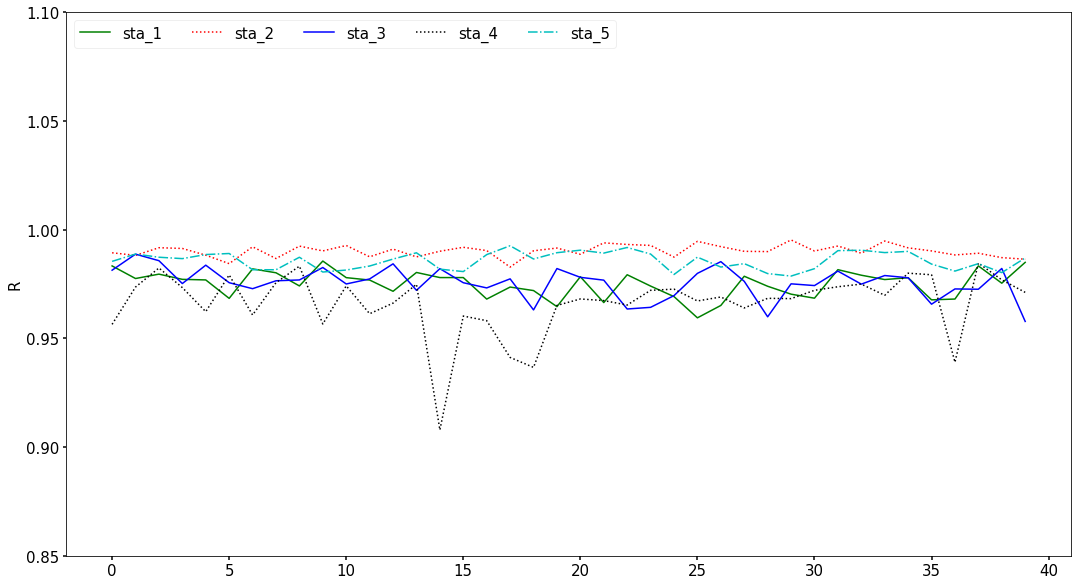

In [13]:
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=(18,10))
plt.plot( out.loc['sta_1'].values,'g-',linewidth=1.5)
plt.plot( out.loc['sta_2'].values,'r:', linewidth=1.5)
plt.plot( out.loc['sta_3'].values,'b-', linewidth=1.5)
plt.plot( out.loc['sta_4'].values,'k:', linewidth=1.5)
plt.plot( out.loc['sta_5'].values,'c-.', linewidth=1.5)

plt.legend(labels=['sta_1','sta_2','sta_3','sta_4','sta_5'], loc=2, prop={'size': 15}, ncol=5, framealpha=0.3)
plt.tick_params(labelcolor='k', labelsize='15', width=1.5)
#plt.ylabel("TS",fontsize=15)
plt.ylabel("R",fontsize=15)
#ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(30))#设定坐标轴的显示的刻度间隔
x_major_locator=MultipleLocator(5)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.05)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
#plt.xlim(-0.5,40)
#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白
plt.ylim(0.85,1.1)
#把y轴的刻度范围设置为-5到110，同理，-5不会标出来，但是能看到一点空白
plt.savefig("win_R.png",dpi=100)
plt.show()


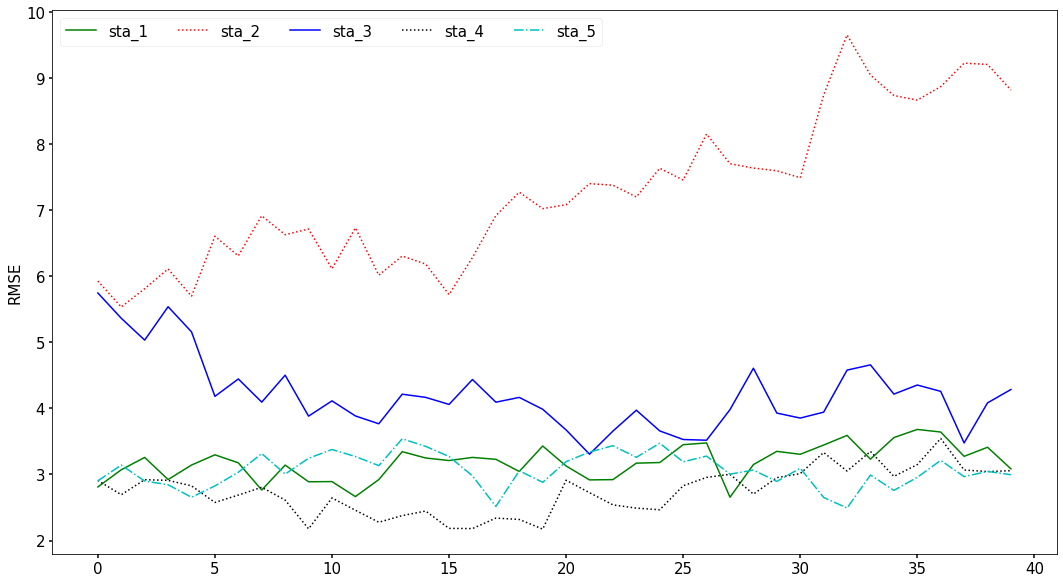

In [16]:
plt.figure(figsize=(18,10))
plt.plot( out3.loc['sta_1'].values,'g-',linewidth=1.5)
plt.plot( out3.loc['sta_2'].values,'r:', linewidth=1.5)
plt.plot( out3.loc['sta_3'].values,'b-', linewidth=1.5)
plt.plot( out3.loc['sta_4'].values,'k:', linewidth=1.5)
plt.plot( out3.loc['sta_5'].values,'c-.', linewidth=1.5)

plt.legend(labels=['sta_1','sta_2','sta_3','sta_4','sta_5'], loc=2, prop={'size': 15}, ncol=5, framealpha=0.3)
plt.tick_params(labelcolor='k', labelsize='15', width=1.5)
#plt.ylabel("TS",fontsize=15)
plt.ylabel("RMSE",fontsize=15)
#ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(30))#设定坐标轴的显示的刻度间隔
x_major_locator=MultipleLocator(5)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(1.0)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
#plt.xlim(-0.5,40)
#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白
#plt.ylim(0.6,1.1)
#把y轴的刻度范围设置为-5到110，同理，-5不会标出来，但是能看到一点空白
plt.savefig("win_RMSE.png",dpi=100)
plt.show()

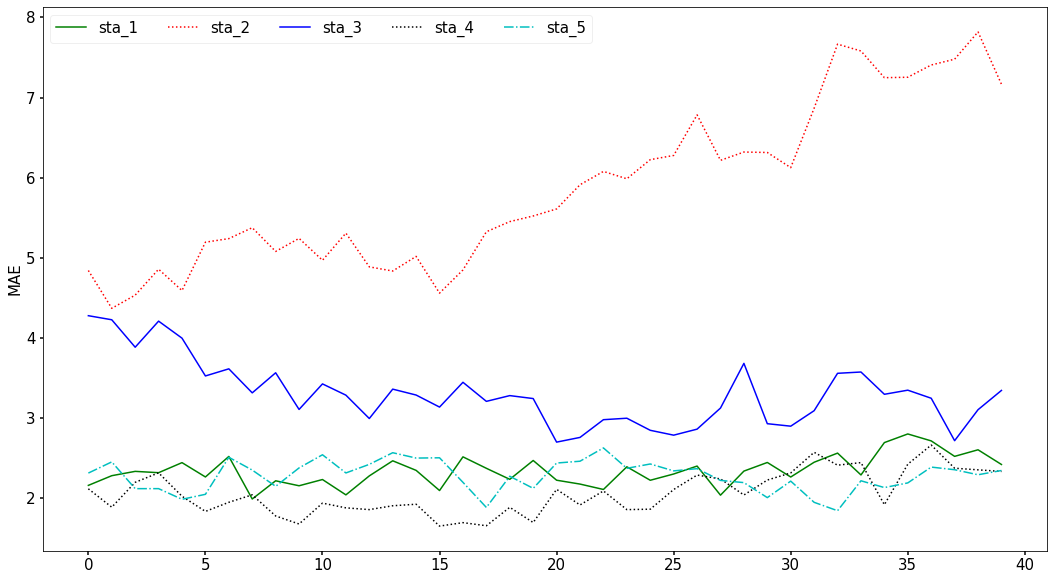

In [17]:
plt.figure(figsize=(18,10))
plt.plot( out4.loc['sta_1'].values,'g-',linewidth=1.5)
plt.plot( out4.loc['sta_2'].values,'r:', linewidth=1.5)
plt.plot( out4.loc['sta_3'].values,'b-', linewidth=1.5)
plt.plot( out4.loc['sta_4'].values,'k:', linewidth=1.5)
plt.plot( out4.loc['sta_5'].values,'c-.', linewidth=1.5)

plt.legend(labels=['sta_1','sta_2','sta_3','sta_4','sta_5'], loc=2, prop={'size': 15}, ncol=5, framealpha=0.3)
plt.tick_params(labelcolor='k', labelsize='15', width=1.5)
#plt.ylabel("TS",fontsize=15)
plt.ylabel("MAE",fontsize=15)
#ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(30))#设定坐标轴的显示的刻度间隔
x_major_locator=MultipleLocator(5)
#把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(1.0)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
#把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)
#把y轴的主刻度设置为10的倍数
#plt.xlim(-0.5,40)
#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白
#plt.ylim(0.6,1.1)
#把y轴的刻度范围设置为-5到110，同理，-5不会标出来，但是能看到一点空白
plt.savefig("win_MAE.png",dpi=100)
plt.show()